# Código en Python - Anisotropías en H_0 para datos de NED

## Ajuste Monte Carlo para ajustar z vs. d a una función lineal

Este ajuste sólo tiene que ser hecho una vez. Si se quiere saltar este paso e ir directamente a la búsqueda de las coordenadas del vector dipolo, [clic aquí](anisotropiaschi2.ipynb).

La primera parte del código es hacer un ajuste lineal de z vs. D con un método Monte Carlo. Esto se hace para tener en cuenta los errores en z y D que aparecen en la base de datos.

Lo primero es importar los paquetes numpy (operaciones numéricas básicas) y pandas (tratamiento de bases de datos).

In [3]:
import numpy as np
import pandas as pd
niter=10000 # Número de iteraciones
fout = open("fitresults.txt","w") # Archivo de salida

A continuación usamos pandas para leer la base de datos, que quedará almacenada en 'df'. Con los nombres de las columnas definimos las variables que vamos a usar. Los datos de 'nedpaper.csv' salen de 'query4.txt' con corte a 35 Mpc y tomando únicamente datos con errores (y que no sean muy grandes).

In [4]:
df = pd.read_csv('nedpaper.csv', index_col=0)
x=df.dis
sigx=df.dis_d
y=df.zz
sigy=df.zz_d

Bloque de corrección del dipolo principal, es decir la velocidad (o el z) de la Vía Láctea respecto al Fondo de Radiación de Microondas.

In [5]:
c_kmsec = 299792.458
r2d = 57.295779513082321
Vcbr = 371.0
zcbr = Vcbr/c_kmsec
ell_cbr = 264.14/r2d
bb_cbr  = 48.26/r2d
ell = df.Glon/r2d
bb  = df.Glat/r2d
znew=df.zz+zcbr*(np.sin(bb)*np.sin(bb_cbr) + np.cos(bb)*np.cos(bb_cbr)*np.cos(ell - ell_cbr))
y=znew

Ahora hacemos el ajuste por mínimos cuadrados (sin peso estadístico) para obtener un valor preliminar para !H_0=z/d=b. 

In [6]:
num=len(x) # contamos el número de filas
sy=y.sum(axis=0)
sx=x.sum(axis=0)
xx=x*x
sxx=xx.sum(axis=0)
xy=x*y
sxy=xy.sum(axis=0)
delta=delta=num*sxx-(sx**2)
# a=(sy*sxx-sx*sxy)/delta
b=(num*sxy-sx*sy)/delta

Hacemos un nuevo ajuste por mínimos cuadrados usando como peso estadístico el error en cuadratura, para obtener un mejor valor para !H_0

In [7]:
eps=np.sqrt(sigy**2+(b*sigx)**2)
w=1/(eps**2)
wy=y*w
wx=x*w
wx2=x*wx
wxy=wx*y
sw=w.sum(axis=0)
swy=wy.sum(axis=0)
swx=wx.sum(axis=0)
swx2=wx2.sum(axis=0)
swxy=wxy.sum(axis=0)
delta=sw*swx2-(swx**2)
# a1=(swy*swx2-swx*swxy)/delta
b1=(sw*swxy-swx*swy)/delta

Con el último ajuste mejoramos el error en cuadratura, que será el peso estadístico para los ajustes lineales que van en el método Monte Carlo.

In [8]:
epsmc=np.sqrt(sigy**2+(b1*sigx)**2)
w=1/(epsmc**2)
fout.write("%s,%s,%s\n" % ('Col','AMC','BMC')) # columnas para la salida de cada ajuste MC

La diferencia entre los errores iniciales y los actualizados es del orden del 4%

In [9]:
np.mean(100*np.abs(eps-epsmc)/eps)

3.8668264802392085

El método Monte Carlo usado aquí se basa en aleatorizar los valores de z y d con ayuda de los errores que proveen los datos. Esto lo hace la función de numpy llamada random.normal. Esto puede tomar un rato.

In [10]:
for k in range (1,niter):
#    zzran = np.random.normal(df.zz,df.zz_d)
    zzran = np.random.normal(znew,df.zz_d)
    disran=np.random.normal(df.dis,df.dis_d)
    x=disran
    y=zzran
    wy=y*w
    wx=x*w
    wx2=x*wx
    wxy=wx*y
    sw=w.sum(axis=0)
    swy=wy.sum(axis=0)
    swx=wx.sum(axis=0)
    swx2=wx2.sum(axis=0)
    swxy=wxy.sum(axis=0)
    delta=sw*swx2-(swx**2)
    amc=(swy*swx2-swx*swxy)/delta
    bmc=(sw*swxy-swx*swy)/delta
    fout.write("%d, %s, %s\n" % (k,amc,bmc))
fout.close()

Los datos quedan listos para ser leídos en dfmc.

In [11]:
dfmc=pd.read_csv('fitresults.txt', index_col=0)

Ahora usaremos pylab, un ambiente que nos permite usar muchas funciones numéricas y también graficar.

In [12]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = 12, 8

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


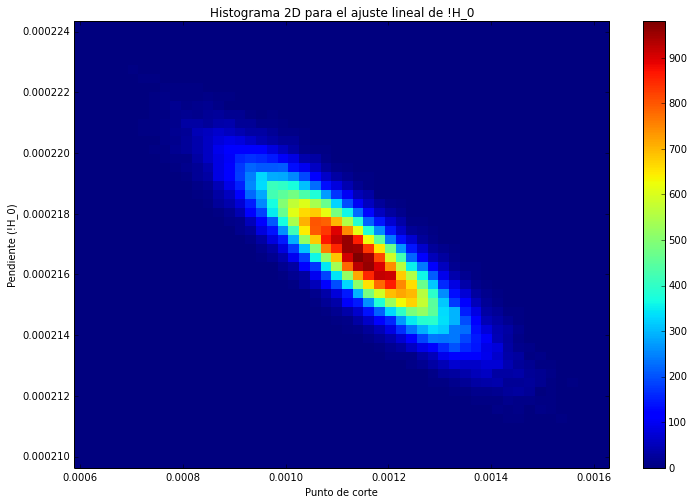

In [45]:
plt.title("Histograma 2D para el ajuste lineal de !H_0")
plt.xlabel("Punto de corte")
plt.ylabel("Pendiente (!H_0)")
plt.hist2d(dfmc.AMC,dfmc.BMC,bins=50)
colorbar()
plt.show()

Con lo anterior, pasamos a la búsqueda del vector dipolo [aquí](anisotropiaschi2.ipynb)

Histograma con corrección de velocidad respecto al CMB.

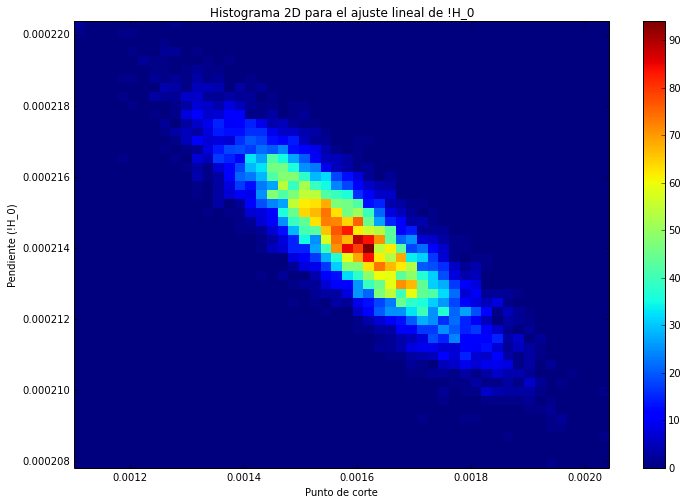

In [13]:
plt.title("Histograma 2D para el ajuste lineal de !H_0")
plt.xlabel("Punto de corte")
plt.ylabel("Pendiente (!H_0)")
plt.hist2d(dfmc.AMC,dfmc.BMC,bins=50)
colorbar()
plt.show()

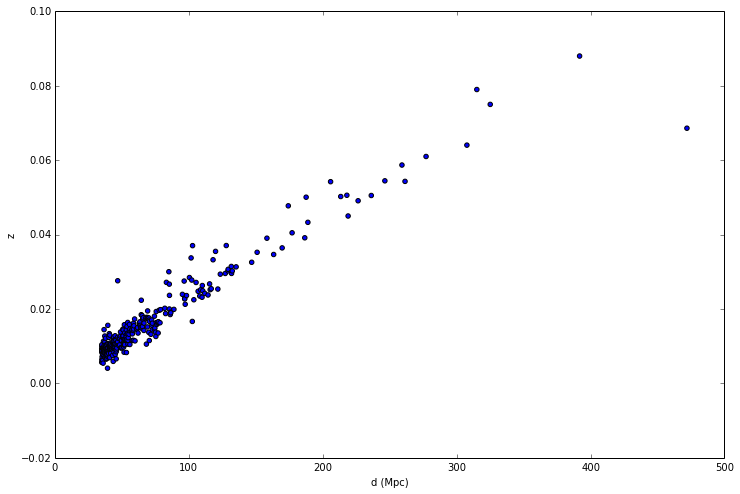

In [15]:
plt.scatter(df.dis,df.zz)
plt.xlabel("d (Mpc)")
plt.ylabel("z")
plt.show()